In [ ]:
!pip3 install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 18.7 MB/s eta 0:00:00


In [ ]:
## 라이브러리 import

import gymnasium as gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt

In [ ]:
#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
lmbda         = 0.95
eps_clip      = 0.1
K_epoch       = 3
T_horizon     = 20

In [ ]:
class PPO(nn.Module):
    def __init__(self):
        super(PPO, self).__init__()
        self.data = []

        self.fc1   = nn.Linear(4,256)
        self.fc_pi = nn.Linear(256,2)
        self.fc_v  = nn.Linear(256,1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def pi(self, x, softmax_dim = 0):
        x = F.relu(self.fc1(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.relu(self.fc1(x))
        v = self.fc_v(x)
        return v

    def put_data(self, transition):
        self.data.append(transition)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for transition in self.data:
            s, a, r, s_prime, prob_a, done = transition

            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_mask = 0 if done else 1
            done_lst.append([done_mask])

        s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
                                          torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
                                          torch.tensor(done_lst, dtype=torch.float), torch.tensor(prob_a_lst)
        self.data = []
        return s, a, r, s_prime, done_mask, prob_a

    def train_net(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for i in range(K_epoch):
            td_target = r + gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().numpy()

            advantage_lst = []
            advantage = 0.0
            for delta_t in delta[::-1]:
                advantage = gamma * lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()
            advantage = torch.tensor(advantage_lst, dtype=torch.float)

            pi = self.pi(s, softmax_dim=1)
            pi_a = pi.gather(1,a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))  # a/b == exp(log(a)-log(b))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-eps_clip, 1+eps_clip) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(self.v(s) , td_target.detach())

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

In [ ]:
def main():
    env = gym.make('CartPole-v1')
    model = PPO()
    score = 0.0
    avg_scores = []
    print_interval = 20
    best_score = -float('inf')

    for n_epi in range(10000):
        s, _ = env.reset()
        done = False
        truncated = False
        while not (done or truncated):
            for t in range(T_horizon):
                prob = model.pi(torch.from_numpy(s).float())
                m = Categorical(prob)
                a = m.sample().item()
                s_prime, r, done, truncated, info = env.step(a)

                model.put_data((s, a, r/100.0, s_prime, prob[a].item(), done))
                s = s_prime

                score += r
                if done:
                    break

            model.train_net()

        if score >= best_score:
            best_score = score
            torch.save(model.state_dict(), f"ppo_cartpole{n_epi}_.pth")
            print(f"New best score: {best_score}. Model saved.")

        if n_epi%print_interval==0 and n_epi!=0:
            avg_score = score / print_interval
            avg_scores.append(avg_score)  # 평균 점수 저장
            print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
            score = 0.0


    env.close()
    plt.plot(avg_scores)
    plt.xlabel('Episodes (x20)')
    plt.ylabel('Average Score')
    plt.title('Average Score vs Episodes')
    plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<ipython-input-4-8afea052ea9b>:38: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  s,a,r,s_prime,done_mask, prob_a = torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \


New best score: 24.0. Model saved.
New best score: 44.0. Model saved.
New best score: 53.0. Model saved.
New best score: 66.0. Model saved.
New best score: 102.0. Model saved.
New best score: 125.0. Model saved.
New best score: 143.0. Model saved.
New best score: 158.0. Model saved.
New best score: 200.0. Model saved.
New best score: 215.0. Model saved.
New best score: 226.0. Model saved.
New best score: 247.0. Model saved.
New best score: 261.0. Model saved.
New best score: 272.0. Model saved.
New best score: 291.0. Model saved.
New best score: 315.0. Model saved.
New best score: 326.0. Model saved.
New best score: 345.0. Model saved.
New best score: 358.0. Model saved.
New best score: 369.0. Model saved.
New best score: 384.0. Model saved.
# of episode :20, avg score : 19.2
New best score: 403.0. Model saved.
New best score: 418.0. Model saved.
New best score: 432.0. Model saved.
# of episode :40, avg score : 21.6
New best score: 466.0. Model saved.
New best score: 542.0. Model saved

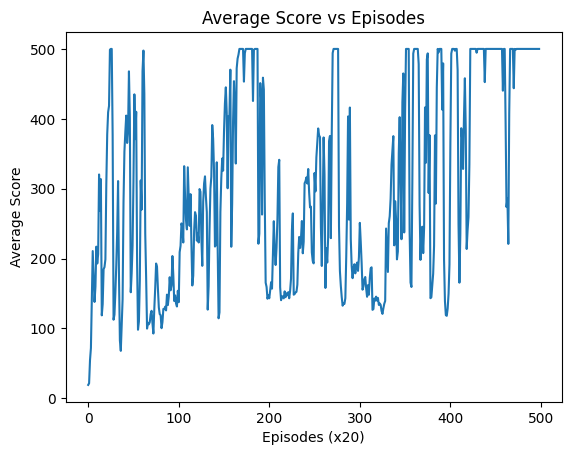

In [ ]:
main()